#Conectamos a google drive e importamos librerias

In [ ]:
# Se conecta al Drive:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle #para guardado de datos
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Conv2D, AveragePooling2D, BatchNormalization, Dropout, MaxPooling2D,RandomFlip,RandomRotation,MaxPool2D
from keras.applications.vgg16 import VGG16

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Para importar el Helper
%cd "/content/drive/Shareddrives/Redes neuronales/TP3"
!pip install import-ipynb
import import_ipynb
from Helper import *

/content/drive/Shareddrives/Redes neuronales/TP3
importing Jupyter notebook from Helper.ipynb
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  


# Cargamos los datos

In [ ]:
X_train = np.load("/content/drive/Shareddrives/Redes neuronales/TP3/Dataset original/X_train.npy")
Y_train = np.load("/content/drive/Shareddrives/Redes neuronales/TP3/Dataset original/y_train.npy")
X_test = np.load("/content/drive/Shareddrives/Redes neuronales/TP3/Dataset original/X_test.npy")

# Dividimos entre datasets de entrenamiento y validación

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.1)

# Paso a float, normalizamos y categorizamos

In [ ]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = X_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

In [ ]:
y_train_categorical = to_categorical(y_train,100)
y_val_categorical = to_categorical(y_valid,100)

# Creación y entrenamiento del modelo de transfer learning




## Se instancia el modelo VGG16 y se cargan pesos pre entrenados con imagenet

In [ ]:
preproc=VGG16(include_top = False, pooling = None, weights="imagenet",input_shape=(32,32,3))
preproc.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

## Se congelan todas las capas en el modelo base configurando trainable= False

In [ ]:
for layer in preproc.layers:
    layer.trainable=False

## Extacción de características: se corre el conjunto de datos por el modelo y se guardan las salidas del modelo base.

In [ ]:
x_pre_train=preproc.predict(x_train)
x_pre_valid=preproc.predict(x_valid)

In [ ]:
x_pre_train[0].shape

(1, 1, 512)

## Se crea un nuevo modelo

In [ ]:
input_preproc=Input(shape=(1,1,512))

net=Flatten()(input_preproc)

net=Dense(units=256, activation='relu')(net)
net=Dropout(0.2)(net)
net=Dense(units=256, activation='relu')(net)
net=Dropout(0.2)(net)
net=Dense(units=100, activation = 'softmax')(net)

model=Model(input_preproc,net)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               2570

## Se entrena el nuevo modelo con el output de modelo preentrenado

In [ ]:
# Callbacks
checkpoint_file =f"/content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/transfer_learning.hdf5"

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [ ]:
batch_size = 64
epocs = 100

history = model.fit(x_pre_train, 
        y_train_categorical,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_pre_valid, y_val_categorical),
        callbacks=[checkpointer, earlystop],
    )

Epoch 1/100
704/704 [==============================] - ETA: 0s - loss: 4.5583 - accuracy: 0.0270
Epoch 00001: val_accuracy improved from -inf to 0.07200, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/transfer_learning.hdf5
704/704 [==============================] - 4s 5ms/step - loss: 4.5583 - accuracy: 0.0270 - val_loss: 4.4316 - val_accuracy: 0.0720
Epoch 2/100
696/704 [============================>.] - ETA: 0s - loss: 4.3322 - accuracy: 0.0654
Epoch 00002: val_accuracy improved from 0.07200 to 0.10820, saving model to /content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/transfer_learning.hdf5
704/704 [==============================] - 3s 4ms/step - loss: 4.3306 - accuracy: 0.0654 - val_loss: 4.0965 - val_accuracy: 0.1082
Epoch 3/100
702/704 [============================>.] - ETA: 0s - loss: 4.0315 - accuracy: 0.0911
Epoch 00003: val_accuracy improved from 0.10820 to 0.14200, saving model to /content/drive/Shareddrives/Redes neuron

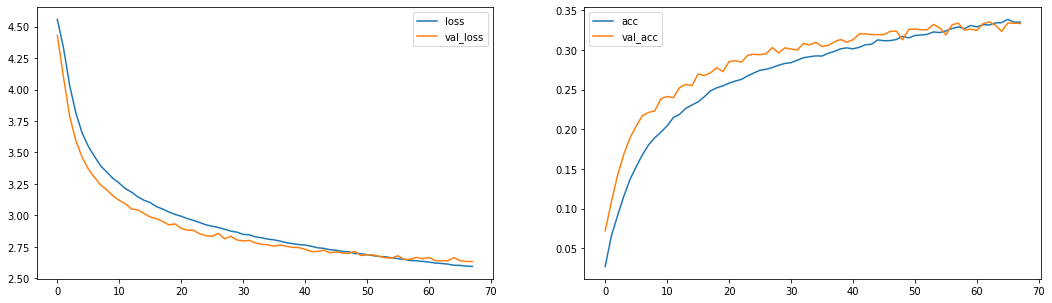

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18,5))
ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()

ax2.plot(history.history['accuracy'], label="acc")
ax2.plot(history.history['val_accuracy'], label="val_acc")
ax2.legend()
plt.show();

In [ ]:
model.load_weights(checkpoint_file)

## Fine-tuning:

Este paso es opcional, en este caso se hace, para obtener mejoras a pesar de que puede conducir a un sobreajuste rápido. En Fine tunning, se descongela parte o todo el modelo base y se vuelve a entrenar tood el modelo de principio a fin con una tasa de aprendizaje muy baja.


In [ ]:
total_model_output=model(preproc.output)
total_model=Model(preproc.input,total_model_output)
total_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

###Se descongela parte del modelo base

In [ ]:
for layer in preproc.layers:
    layer.trainable=True
total_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

###Se vuelve a entrenar todo el modelo de principio a fin

In [ ]:
total_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Callbacks
checkpoint_file='/content/drive/Shareddrives/Redes neuronales/TP3/Modelos entrenados/cifar10-cnn-TL-VGG16_fine_tunning.hdf5'
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=2)
checkpointer = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_file, verbose=1, save_best_only=True)

In [ ]:
batch_size = 64
epocs = 100

history = total_model.fit(x_train, 
        y_train_categorical,
        epochs=epocs, batch_size=batch_size, 
        verbose=1, 
        validation_data = (x_valid, y_val_categorical),
        callbacks=[checkpointer, earlystop],
    )

Epoch 1/100
704/704 [==============================] - 59s 80ms/step - loss: 2.8704 - accuracy: 0.2832 - val_loss: 3.4979 - val_accuracy: 0.2234
Epoch 2/100
704/704 [==============================] - 55s 79ms/step - loss: 2.1394 - accuracy: 0.4232 - val_loss: 2.0779 - val_accuracy: 0.4406
Epoch 3/100
704/704 [==============================] - 55s 79ms/step - loss: 1.8391 - accuracy: 0.4909 - val_loss: 3.2590 - val_accuracy: 0.2908
Epoch 4/100
704/704 [==============================] - 56s 80ms/step - loss: 1.6425 - accuracy: 0.5374 - val_loss: 2.7464 - val_accuracy: 0.3500
Epoch 5/100
704/704 [==============================] - 56s 79ms/step - loss: 1.4594 - accuracy: 0.5812 - val_loss: 4.9130 - val_accuracy: 0.1778
Epoch 6/100
704/704 [==============================] - 55s 79ms/step - loss: 1.3202 - accuracy: 0.6172 - val_loss: 3.6033 - val_accuracy: 0.3068
Epoch 7/100
704/704 [==============================] - 56s 79ms/step - loss: 1.1655 - accuracy: 0.6563 - val_loss: 1.8964 - val_ac

# Conclusiones

Se ve que a pesar de que los resultados mejoran, se conduce a un sobreajuste rápido.